In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

environments = ['HalfCheetah-v5', 'Hopper-v5', 'Swimmer-v5', 'Ant-v5', 'Walker2d-v5']
discount_factors = {
    'HalfCheetah-v5': 0.99,
    'Hopper-v5': 0.999,
    'Swimmer-v5': 0.9999,
    'Ant-v5': 0.98,
    'Walker2d-v5': 0.99,
    'ALE/BeamRider-v5': 0.99,
    'ALE/MsPacman-v5': 0.99,
    'ALE/Enduro-v5': 0.99
}

## Plots for evaluative feedback

In [2]:
# Compute statistics env per env (due to memory constraints)
results = {}

# helper function
def discounted_sum_numpy(rewards, discount_factor):
    rewards = np.array(rewards)
    n = len(rewards)
    discount_factors = discount_factor ** np.arange(n)
    return np.sum(rewards * discount_factors)

for env in environments:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    feedback_files = [f for f in os.listdir("feedback") if env_name in f]

    # Load data
    for file in feedback_files:
        print(file)
        seed = file.split('.')[0].split('_')[-1]
        with open(f"feedback/{file}", 'rb') as f:
            data = pkl.load(f)
            if env not in results:
                results[env] = []
            
            # compute discounted sum of rewards
            index = np.argsort([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])
            ordered_gt_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])[index]

            # opt gaps
            opt_gaps = -np.array([d for d in data["opt_gaps"]])[index]

            # ratings
            ratings = np.array([d for d in data["ratings"]])[index]

            # demo rewards
            ordered_demo_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["demos"]])[index]

            # store data
            results[env].append((ordered_gt_rews, opt_gaps, ratings, ordered_demo_rews))

ppo_HalfCheetah-v5_912391.pkl
ppo_HalfCheetah-v5_330.pkl
ppo_HalfCheetah-v5_12.pkl
ppo_HalfCheetah-v5_1337.pkl
ppo_HalfCheetah-v5_1789.pkl
ppo_HalfCheetah-v5_1687123.pkl
ppo_Hopper-v5_912391.pkl
ppo_Hopper-v5_12.pkl
ppo_Hopper-v5_330.pkl
ppo_Hopper-v5_1687123.pkl
ppo_Hopper-v5_1789.pkl
ppo_Swimmer-v5_1789.pkl
ppo_Swimmer-v5_1687123.pkl
ppo_Swimmer-v5_12.pkl
ppo_Swimmer-v5_330.pkl
ppo_Swimmer-v5_912391.pkl
ppo_Ant-v5_1687123.pkl
ppo_Ant-v5_912391.pkl
ppo_Ant-v5_1789.pkl
ppo_Ant-v5_330.pkl
ppo_Ant-v5_12.pkl


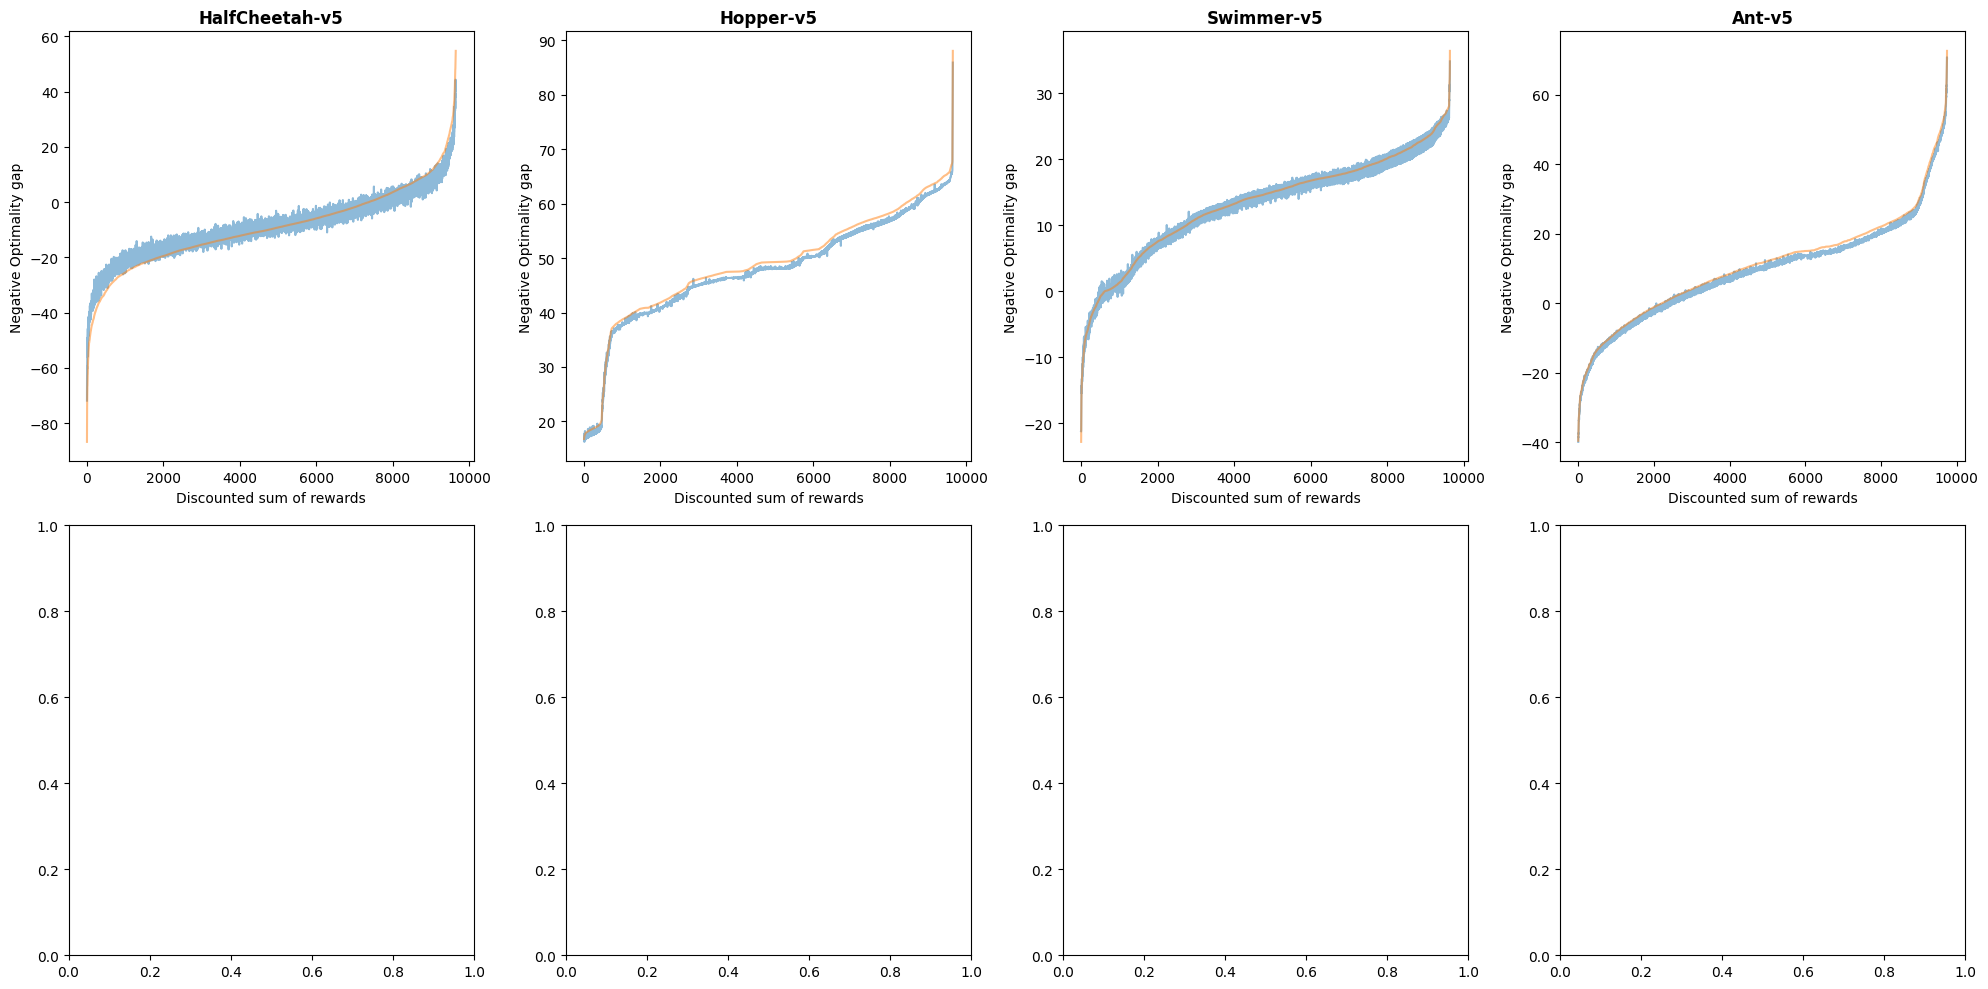

In [5]:
# make grid plot showing opt_gaps (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, env in enumerate(environments):
    ax = axs[i // 4, i % 4]
    for data in results[env][:1]:
        ax.plot(data[1], alpha=0.5)
        ax.plot(data[0], alpha=0.5)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Discounted sum of rewards")
    ax.set_ylabel("Negative Optimality gap")

plt.tight_layout()

plt.savefig("opt_gaps_vs_discounted_sum_of_rewards.png")

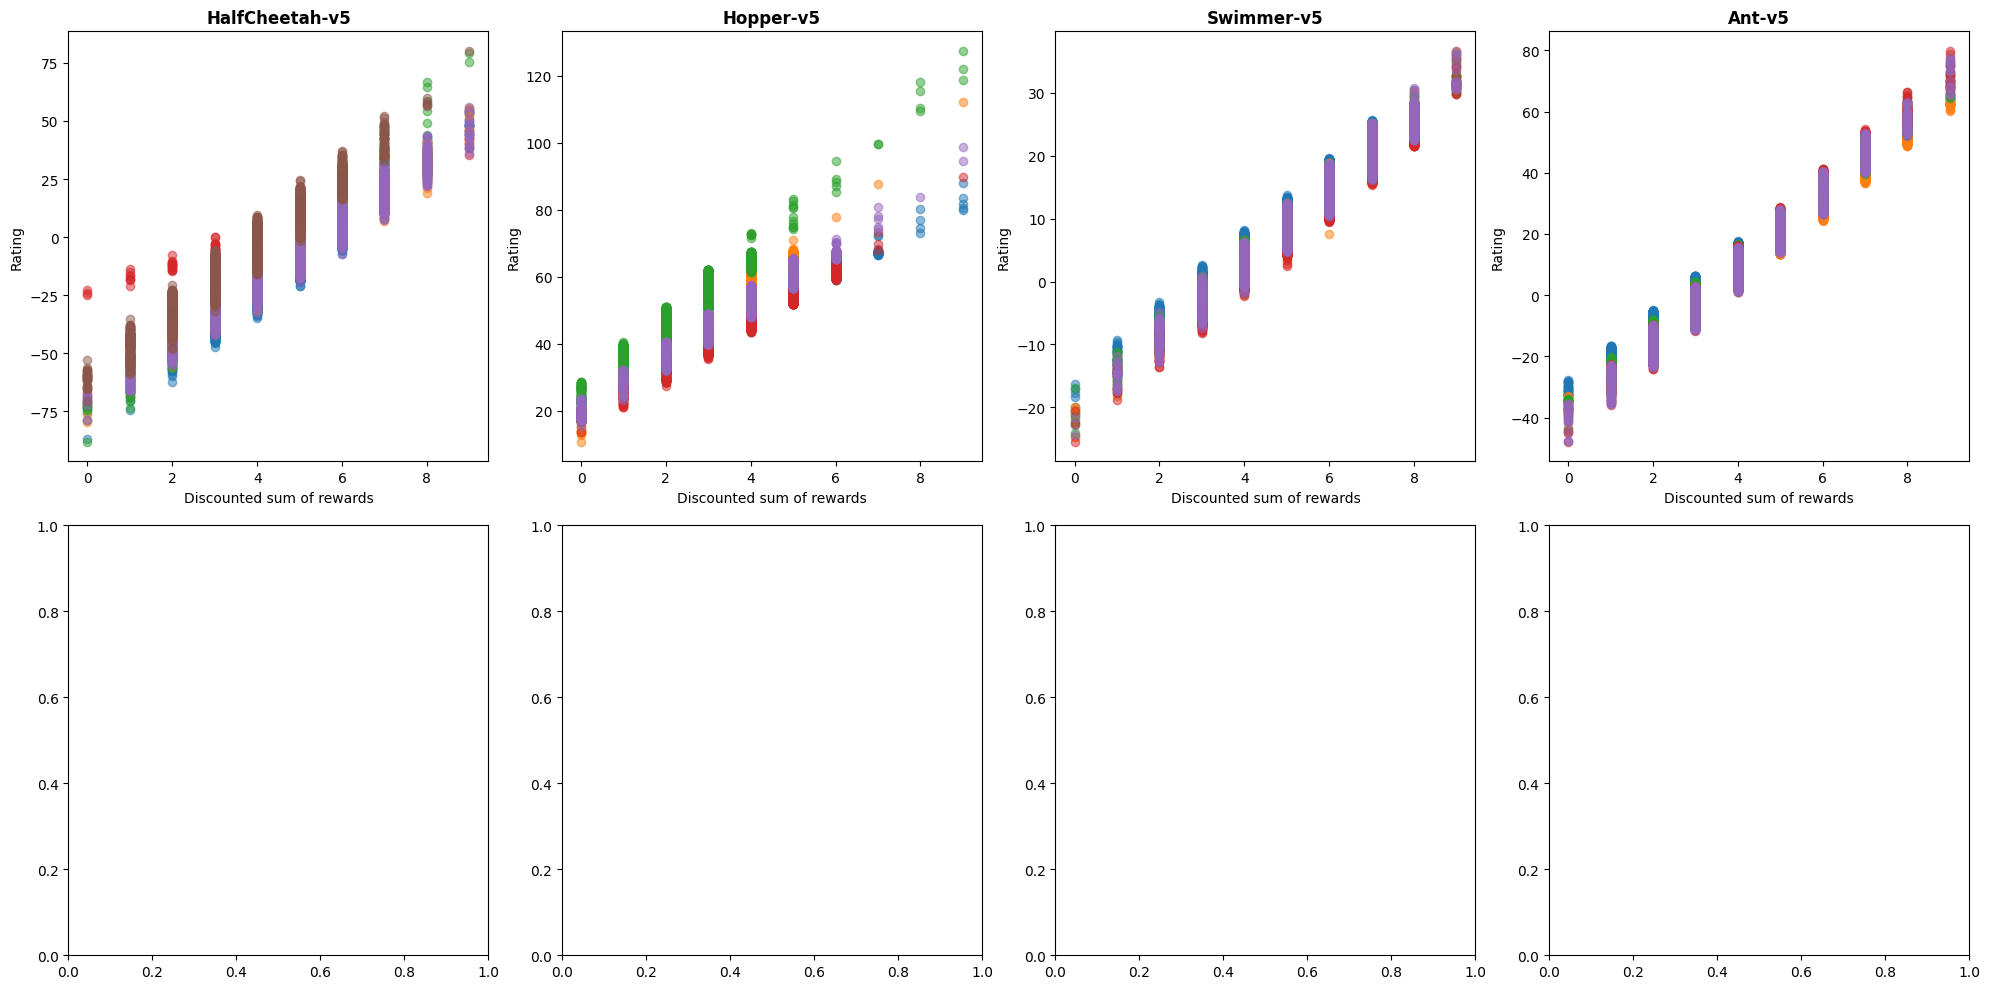

In [6]:
# make grid plot showing ratings (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, env in enumerate(environments):
    ax = axs[i // 4, i % 4]
    for data in results[env]:
        ax.plot(data[2], data[0], 'o', alpha=0.5)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Discounted sum of rewards")
    ax.set_ylabel("Rating")

plt.tight_layout()

plt.savefig("ratings_vs_discounted_sum_of_rewards.png")

## Plots for demonstrative feedback

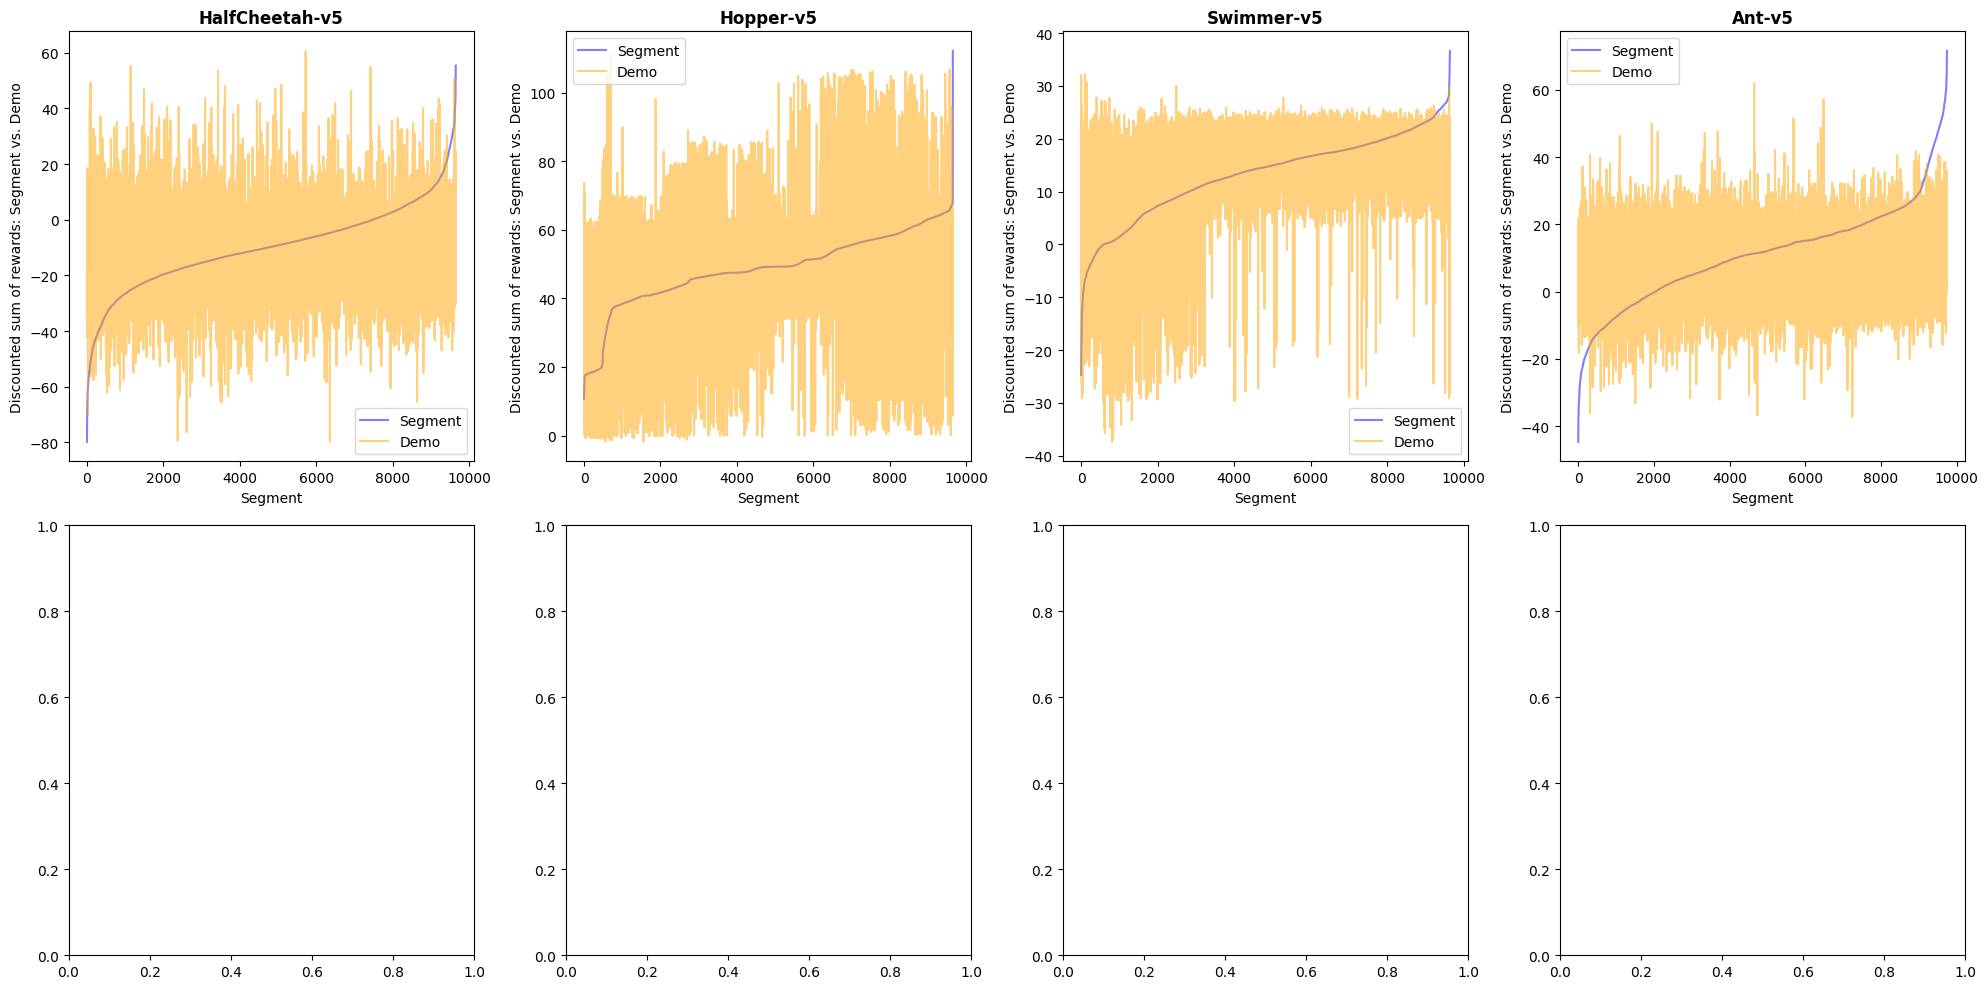

In [7]:
# Instead of ratings, we now want to compare the total rewards between original data ("segments") and demonstrations ("demos").
# make grid plot showing the total rewards for each segment and demo

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, env in enumerate(environments):
    ax = axs[i // 4, i % 4]
    for data in results[env][1:2]:
        steps = np.arange(len(data[0]))
        ax.plot(steps, data[0], label="Segment", alpha=0.5, color='blue')
        ax.plot(steps, data[3], label="Demo", alpha=0.5, color='orange')
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Segment")
    ax.set_ylabel("Discounted sum of rewards: Segment vs. Demo")
    ax.legend()

plt.tight_layout()

plt.savefig("segment_vs_demo_rewards.png")

In [8]:
# In the feedback_video directory, we have some selected segments. The videos are named according to the scheme "segment_env_seed_segmentindex_optgap.mp4" or "demo_env_seed_segmentindex_optgap.mp4".
# We want to create a plot showing some presentative frames (5 for each video) of the segments and demos (Here ther demos are the corrections). It's fine to just take one seed for each environment.
# Ideally, we want a grid of 5 columns and 2 rows for each environment (one row for the segments and one for the demos). And then save a plot for each environment.

import cv2

for env in environments:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    # get all video files matching the environment and seed
    video_files = [f for f in os.listdir("feedback_videos") if env_name in f and seed in f and "segment" in f]
    demo_files = [f for f in os.listdir("feedback_videos") if env_name in f and seed in f and "demo" in f]

    # we want to find the pair of segment and demo videos that have the same segment index but the highest difference in optgap
    opt_gap_diffs = []
    for file in video_files:
        _, _, _, segindex, optgap = file.split('.')[0].split('_')
        
        # find the corresponding demo video (remember the optgap can be different)
        for video in demo_files:
            if segindex in video:
                _, _, _, segindex, optgap_demo = video.split('.')[0].split('_')
                opt_gap_diffs.append((file, video, float(optgap) - float(optgap_demo)))
                break

    # sort by the difference in optgap
    opt_gap_diffs = sorted(opt_gap_diffs, key=lambda x: x[2])

    # take the pair with the highest difference
    video_file = opt_gap_diffs[-1][0]
    demo_file = opt_gap_diffs[-1][1]
   
    cap = cv2.VideoCapture(f"feedback_videos/{video_file}")
    frames = []
    for i in range(5):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * 10)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    cap.release()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, frame in enumerate(frames):
        axs[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
    plt.tight_layout()
    plt.savefig(f"feedback_videos/{video_file.replace('.mp4', '.png')}")
    plt.close()

    cap = cv2.VideoCapture(f"feedback_videos/{demo_file}")
    frames = []
    for i in range(5):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * 10)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    cap.release()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, frame in enumerate(frames):
        axs[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
    plt.tight_layout()
    plt.savefig(f"feedback_videos/{demo_file.replace('.mp4', '.png')}")
    plt.close()

FileNotFoundError: [Errno 2] No such file or directory: 'feedback_videos'

## Plots for Descriptive feedback

In [94]:
# two types of plots: fraction of positive/negative attributions vs. discounted sum of rewards (attributions have the same shape and value range as segment observations, let's classify each attribution value as significant
# if it is at least 50% as large as the observation value). Then we count the fraction of significant positive and negative attributions for each segment and plot them against the discounted sum of rewards.

# Compute statistics env per env (due to memory constraints)
results = {}

# helper function
def discounted_sum_numpy(rewards, discount_factor):
    rewards = np.array(rewards)
    n = len(rewards)
    discount_factors = discount_factor ** np.arange(n)
    return np.sum(rewards * discount_factors)

for env in environments:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    feedback_files = [f for f in os.listdir("feedback") if env_name in f]

    # Load data
    for file in feedback_files[:1]:
        seed = file.split('.')[0].split('_')[-1]
        with open(f"feedback/{file}", 'rb') as f:
            data = pkl.load(f)
            if env not in results:
                results[env] = []
            
            # compute discounted sum of rewards
            index = np.argsort([np.sum([e[2] for e in d]) for d in data["segments"]])
            ordered_gt_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])[index]

            # opt gaps
            attributions = np.array([d[0] for d in data["description"]])[index]
            obs = np.array([np.array([entry[0] for entry in d]) for d in data["segments"]])[index]
            obs_shape = obs[0].squeeze().shape
            single_attr_score = 
            #significant_pos = np.array([np.sum(np.abs(a) > 0.5 * np.abs(s)) for a, s in zip(attributions, data["segments"])])
            significant_positives = np.array([np.sum(a > 0.05) / np.prod(obs_shape) for a, s in zip(attributions, obs)])
            significant_negatives = np.array([np.sum(a < 0.05) / np.prod(obs_shape) for a, s in zip(attributions, obs)])

            # store data
            results[env].append((ordered_gt_rews, significant_positives, significant_negatives))

        print("done with f.b. file")

done with f.b. file
done with f.b. file
done with f.b. file
done with f.b. file


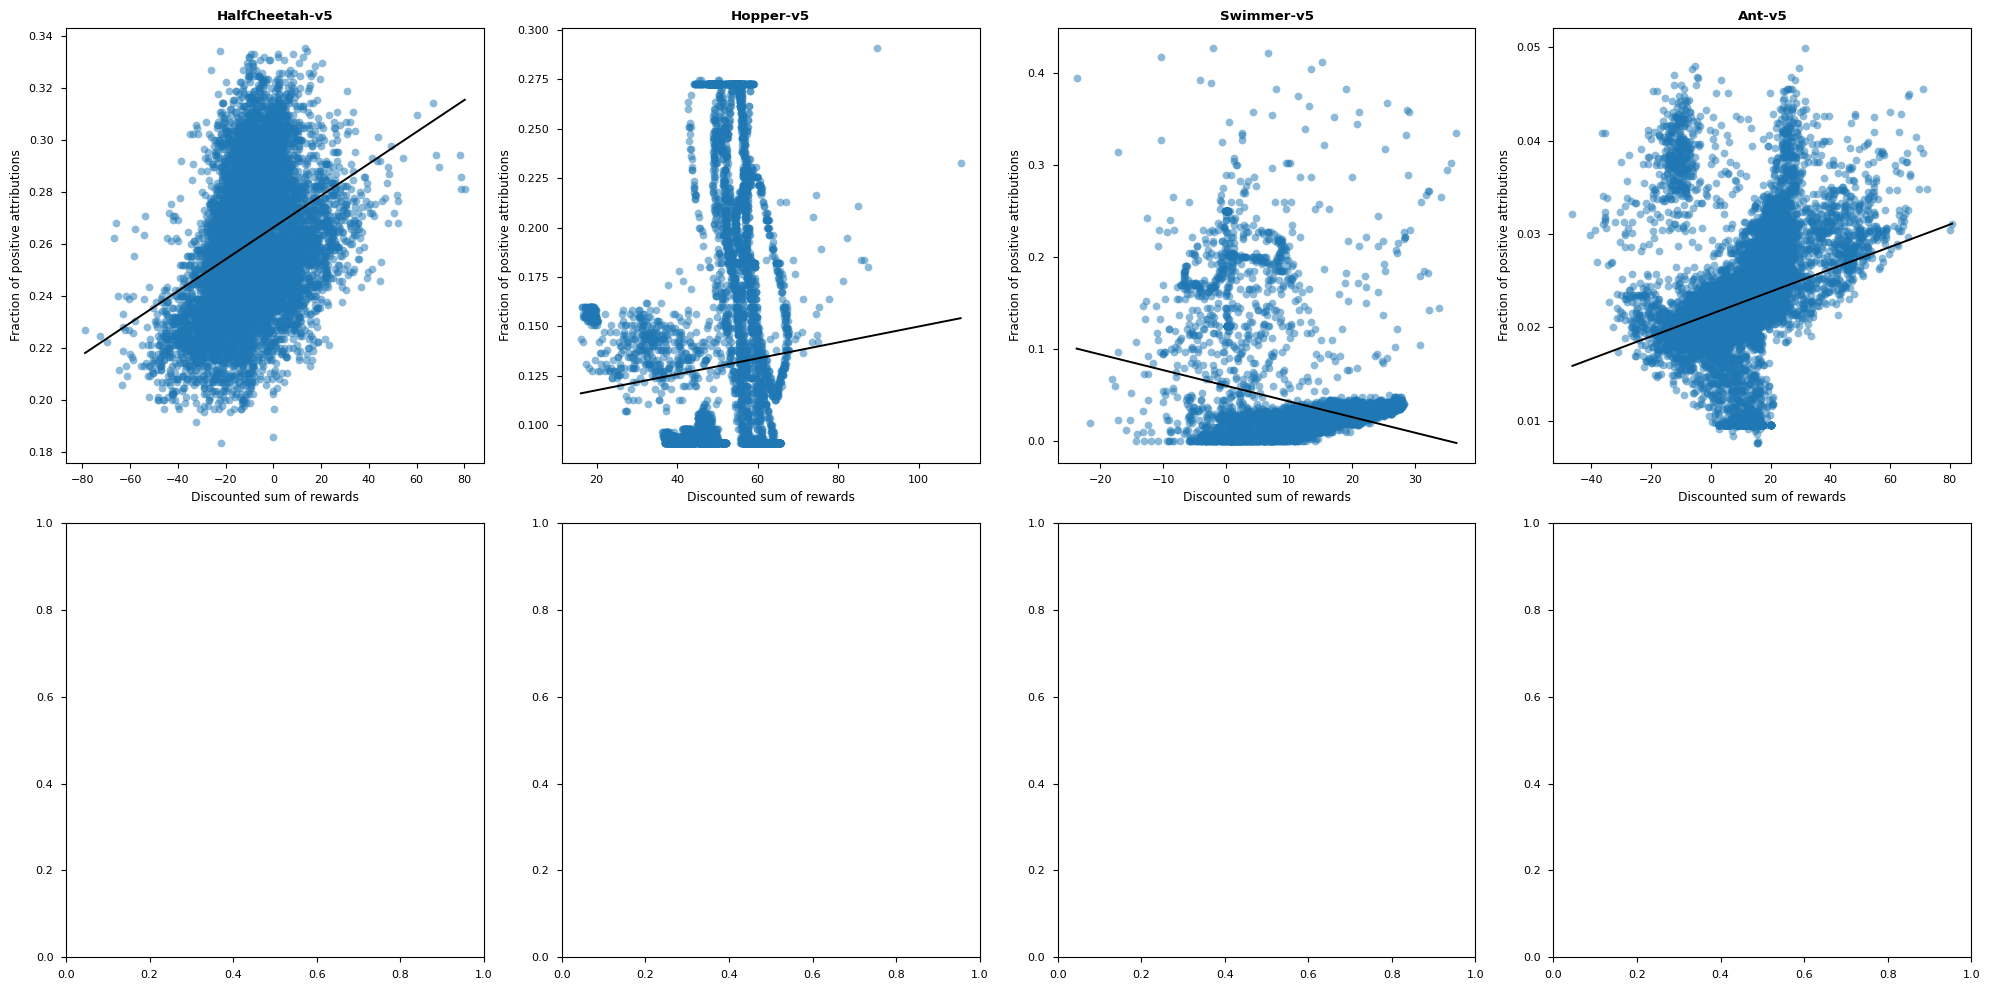

In [95]:
# make grid plot showing significant positive attributions (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, env in enumerate(environments):

    ax = axs[i // 4, i % 4]
    for data in results[env]:
        ax.plot(data[0], data[1], 'o', alpha=0.5)
        b, a = np.polyfit(data[0], data[1], deg=1)
        xseq = np.linspace(np.min(data[0]), np.max(data[0]))
        # Plot regression line
        ax.plot(xseq, a + b * xseq, color="k")
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Discounted sum of rewards")
    ax.set_ylabel("Fraction of positive attributions")

plt.tight_layout()

plt.savefig("significant_positive_attributions_vs_discounted_sum_of_rewards.png")

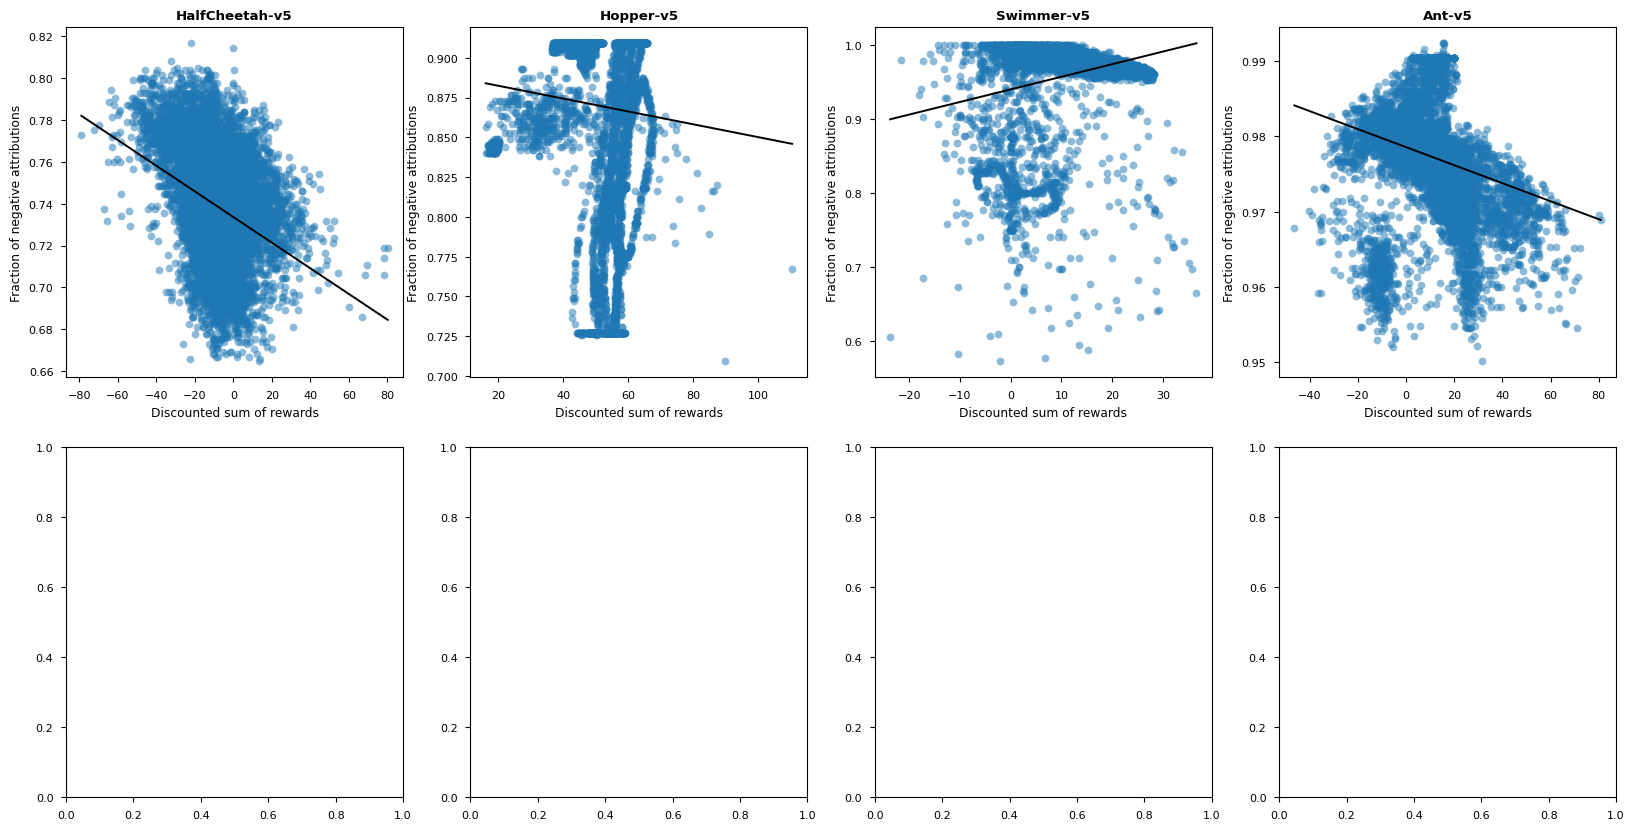

In [96]:
# make grid plot showing significant negative attributions (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, env in enumerate(environments):
    
        ax = axs[i // 4, i % 4]
        for data in results[env]:
            ax.plot(data[0], data[2], 'o', alpha=0.5)
            b, a = np.polyfit(data[0], data[2], deg=1)
            xseq = np.linspace(np.min(data[0]), np.max(data[0]))
            # Plot regression line
            ax.plot(xseq, a + b * xseq, color="k")
        ax.set_title(env, fontweight='bold')
        ax.set_xlabel("Discounted sum of rewards")
        ax.set_ylabel("Fraction of negative attributions")

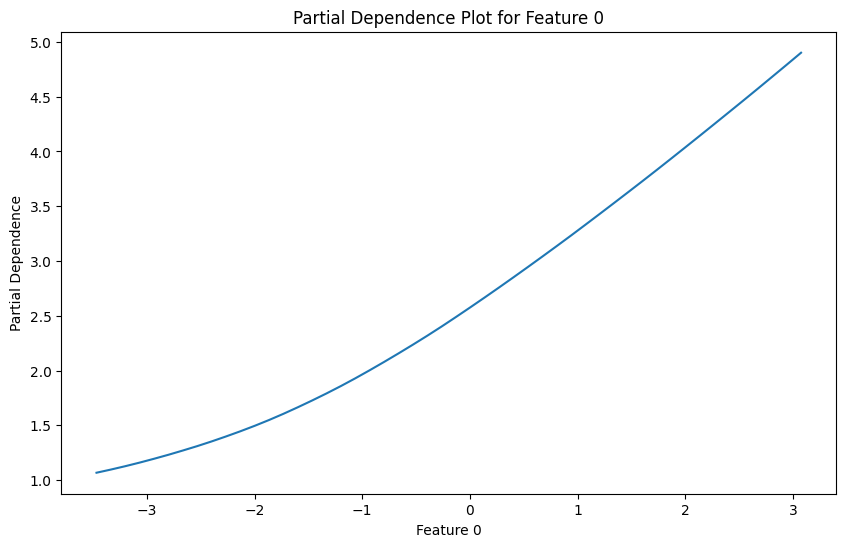

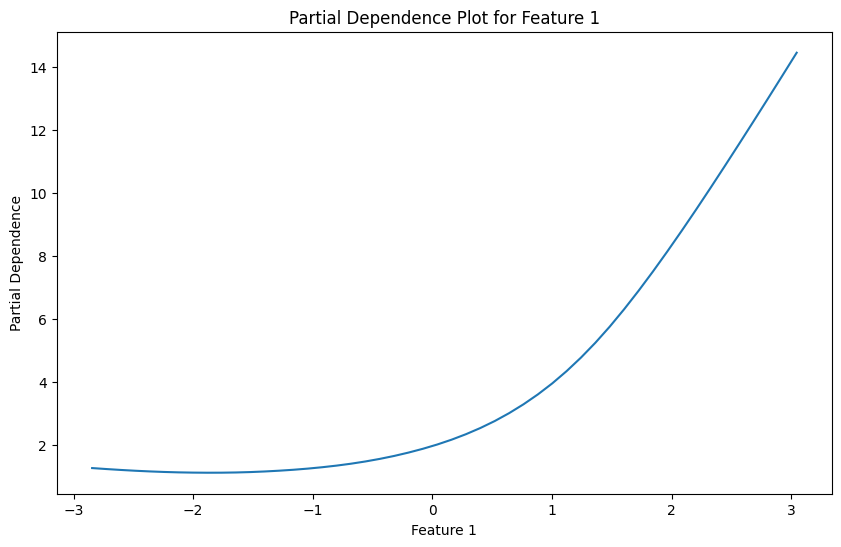

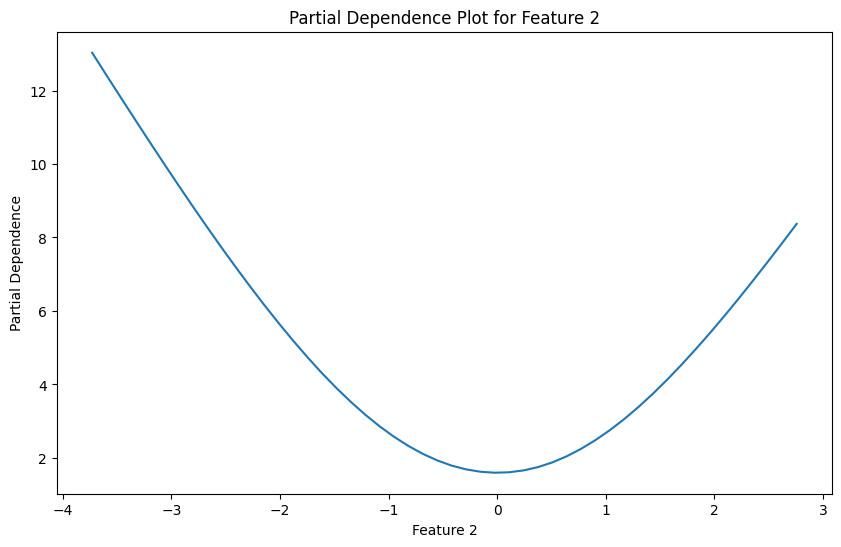

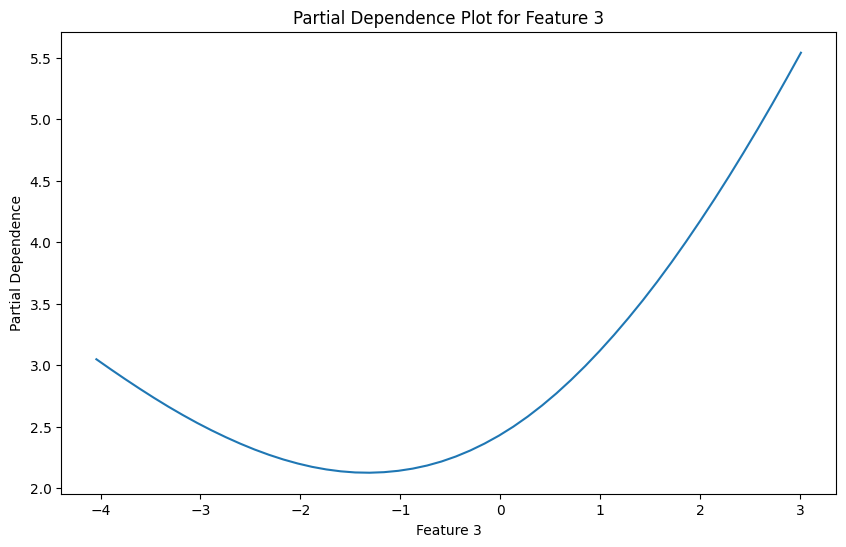

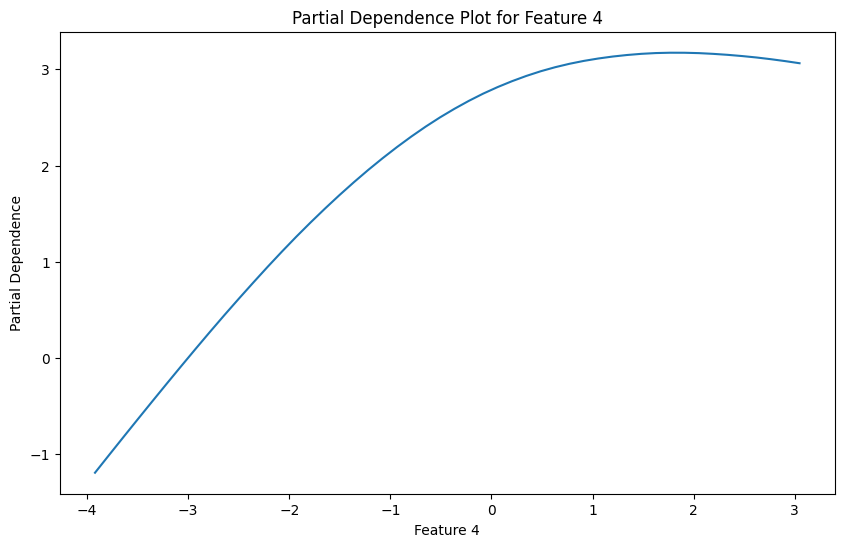

  0%|          | 0/100 [00:00<?, ?it/s]

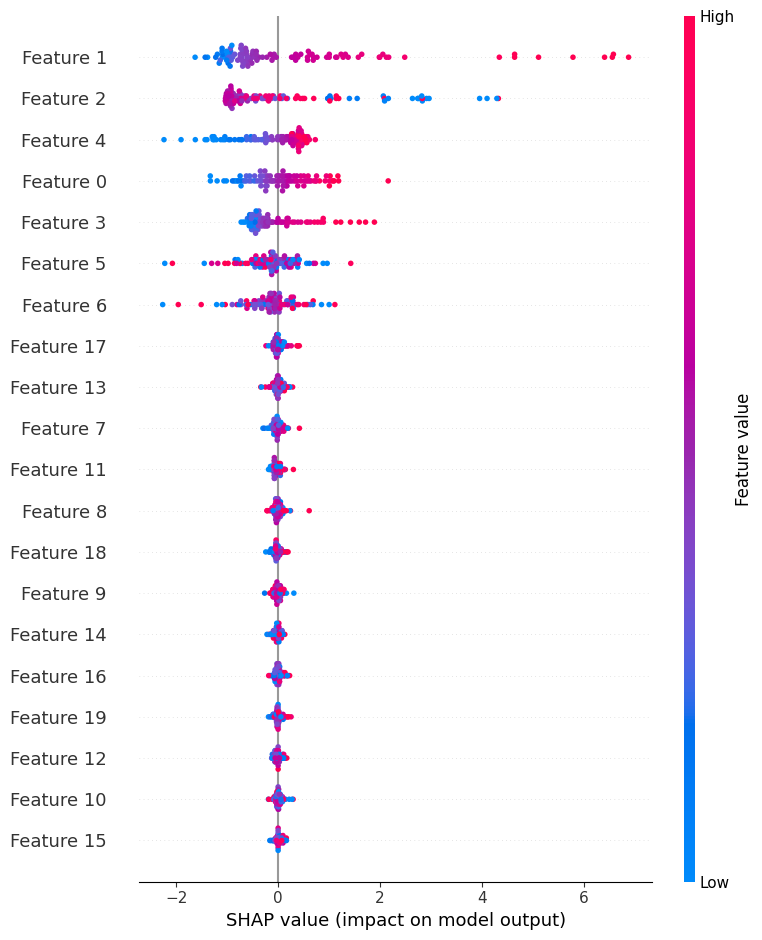

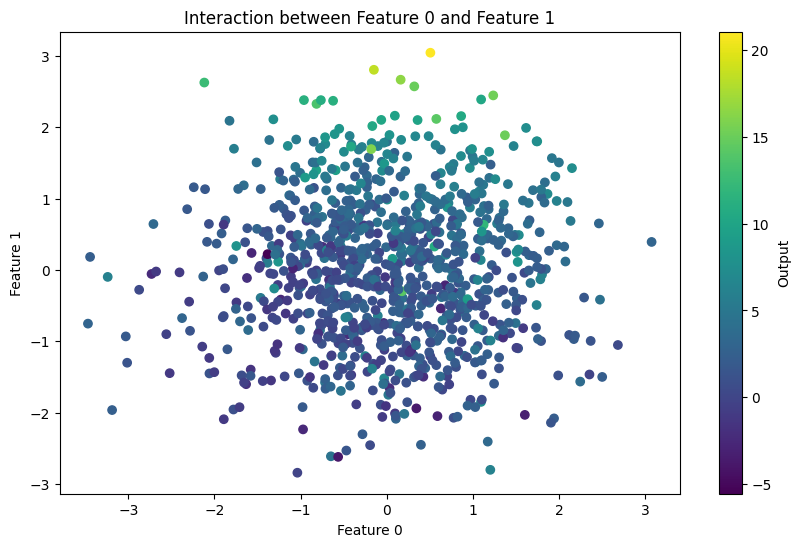

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shap

class SimpleNN(torch.nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Generate synthetic data with non-linear relationships
def generate_nonlinear_data(n_samples=1000, n_features=20):
    X = np.random.randn(n_samples, n_features)
    y = (np.sin(X[:, 0]) + np.exp(X[:, 1]) + X[:, 2]**2 + 
         np.maximum(X[:, 3], 0) + np.minimum(X[:, 4], 0) + 
         X[:, 5] * X[:, 6] + np.random.randn(n_samples) * 0.1)
    return X, y

# Train a simple neural network
def train_model(X, y):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    model = SimpleNN(X.shape[1])
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model

# Custom Partial Dependence Plot function for PyTorch models
def plot_pdp(model, X, feature_idx, num_points=50):
    feature_values = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), num_points)
    pdp_values = []
    
    for value in feature_values:
        X_modified = X.copy()
        X_modified[:, feature_idx] = value
        X_tensor = torch.FloatTensor(X_modified)
        
        with torch.no_grad():
            predictions = model(X_tensor).numpy().flatten()
        
        pdp_values.append(predictions.mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_values, pdp_values)
    plt.title(f"Partial Dependence Plot for Feature {feature_idx}")
    plt.xlabel(f"Feature {feature_idx}")
    plt.ylabel("Partial Dependence")
    plt.show()

# SHAP Analysis
def shap_analysis(model, X):
    def predict(X):
        with torch.no_grad():
            return model(torch.FloatTensor(X)).numpy().reshape(-1)
    
    explainer = shap.KernelExplainer(predict, shap.sample(X, 100))
    shap_values = explainer.shap_values(X[:100])
    
    shap.summary_plot(shap_values, X[:100])

# Feature Interaction (simplified version)
def feature_interaction(X, y, feature1, feature2):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, feature1], X[:, feature2], c=y, cmap='viridis')
    plt.colorbar(label='Output')
    plt.xlabel(f'Feature {feature1}')
    plt.ylabel(f'Feature {feature2}')
    plt.title(f'Interaction between Feature {feature1} and Feature {feature2}')
    plt.show()

# Main execution
X, y = generate_nonlinear_data()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = train_model(X_scaled, y)

# Plot PDP for the first few features
for i in range(5):
    plot_pdp(model, X_scaled, i)

# Run SHAP analysis
shap_analysis(model, X_scaled)

# Plot interaction for the first two features
feature_interaction(X_scaled, y, 0, 1)